from IPython.display import HTML

HTML("""
<div style="background-color: orange; text-align: center;">
  <h2 style="margin: auto; padding: 20px; color: #ffffff;">
    PRÉTRAITEMENT ET ANALYSE DES ACCIDENTS ROUTIERS AU SENEGAL
  </h2>
</div>
""")


In [201]:
from pyspark.sql import SparkSession,Window
from pyspark.sql.functions import *
from pyspark.sql.functions import col, sum as _sum, when
from pyspark.sql.types import StringType, NumericType

In [202]:
# Creation d'une Session Spark
spark = SparkSession.builder.appName("MEMOIRE").getOrCreate()

In [203]:
#Charger le DataSet
df = spark.read.csv("senega.csv", header=True, inferSchema=True)
df.printSchema()


root
 |-- nature-de-l-accident: string (nullable = true)
 |-- sorties-et-victimes: string (nullable = true)
 |-- Unit: string (nullable = true)
 |-- Date: integer (nullable = true)
 |-- Value: integer (nullable = true)



In [204]:
df.show(2)

+--------------------+-------------------+----+----+-----+
|nature-de-l-accident|sorties-et-victimes|Unit|Date|Value|
+--------------------+-------------------+----+----+-----+
|Piéton renversé p...| Nombre d'accidents|NULL|2017| 4149|
|Piéton renversé p...| Nombre d'accidents|NULL|2018| 3684|
+--------------------+-------------------+----+----+-----+
only showing top 2 rows



In [205]:
# Un apercu des colonnes
df.columns

['nature-de-l-accident', 'sorties-et-victimes', 'Unit', 'Date', 'Value']

#### Valeur manquantes

In [206]:

val_manq = df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
])
val_manq = val_manq.toPandas().melt(var_name="collones", value_name="Valeur_Manquantes")
print(val_manq)

               collones  Valeur_Manquantes
0  nature-de-l-accident                  0
1   sorties-et-victimes                  0
2                  Unit                559
3                  Date                  0
4                 Value                  0


#### Supprimer les colonnes ayant un certains seuil de valeur manquantes

In [208]:
##### Compter le nombre de valeur manquantes et le mettre dans un dictionnaire
val_manq = df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).collect()[0].asDict()


In [209]:
##### Garder les variables dont le seuil de valeure manquantes ne depasse pas 60
colon_gar = [col for col, miss in val_manq.items() if miss <= 60]

In [210]:
##### Mettre ces variables dans un dataframe et afficher son schema
df = df.select(colon_gar)
df.printSchema()

root
 |-- nature-de-l-accident: string (nullable = true)
 |-- sorties-et-victimes: string (nullable = true)
 |-- Date: integer (nullable = true)
 |-- Value: integer (nullable = true)



In [211]:
# Verification

val_manq = df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
])
val_manq = val_manq.toPandas().melt(var_name="collones", value_name="Valeur_Manquantes")
print(val_manq)

               collones  Valeur_Manquantes
0  nature-de-l-accident                  0
1   sorties-et-victimes                  0
2                  Date                  0
3                 Value                  0


In [212]:
df.show(2)

+--------------------+-------------------+----+-----+
|nature-de-l-accident|sorties-et-victimes|Date|Value|
+--------------------+-------------------+----+-----+
|Piéton renversé p...| Nombre d'accidents|2017| 4149|
|Piéton renversé p...| Nombre d'accidents|2018| 3684|
+--------------------+-------------------+----+-----+
only showing top 2 rows



from IPython.display import HTML

HTML("""
<div style="background-color: blue; text-align: center;">
  <h2 style="margin: auto; padding: 20px; color: #ffffff;">
    ANALYSE
  </h2>
</div>
""")


##### Nombre total des deces, de blesse et d'accidents par annee

In [218]:
accident_df = df.filter(col("sorties-et-victimes") == "Nombre d'accidents") \
                .groupBy("Date").agg(sum("Value").alias("Total_accidents"))

assistee_df = df.filter(col("sorties-et-victimes") == "Victimes assistées") \
                .groupBy("Date").agg(sum("Value").alias("Total_assistees"))

deces_df = df.filter(col("sorties-et-victimes") == "Victimes décédées") \
                .groupBy("Date").agg(sum("Value").alias("Total_deces"))

tableau = accident_df \
    .join(assistee_df, on="Date", how="fullouter") \
    .join(deces_df, on="Date", how="fullouter") \
    .orderBy("Date")
tableau.show()

+----+---------------+---------------+-----------+
|Date|Total_accidents|Total_assistees|Total_deces|
+----+---------------+---------------+-----------+
|2017|          15841|          25788|        628|
|2018|          16240|          26745|        612|
|2019|          17213|          26720|        745|
|2020|          16158|          25312|        877|
|2021|          19566|          22549|        482|
|2022|          21426|          30944|        718|
|2023|          21184|          31456|        907|
+----+---------------+---------------+-----------+



##### Nombre d'accidents par nature de l'accident

In [229]:
accidents_df = df.filter(col("sorties-et-victimes") == "Nombre d'accidents")

accidents_par_nature = accidents_df.groupBy("nature-de-l-accident") \
                                   .agg(sum("Value").alias("Total_accidents"))

accidents_par_nature.orderBy(col("Total_accidents").desc()).show(truncate=False)

+--------------------------------------------------+---------------+
|nature-de-l-accident                              |Total_accidents|
+--------------------------------------------------+---------------+
|Piéton renversé par un véhicule automobile        |24810          |
|Cyclomoteur renversé par véhicule automobile      |19581          |
|Piéton renversé par un cyclomoteur                |18501          |
|Dérapage et chute de cyclomoteur                  |13731          |
|Collisions entres cyclomoteurs                    |10175          |
|Collision entre véhicules automobiles             |9941           |
|Dérapage suivi de renversement véhicule automobile|6119           |
|Dérapage de véhicule Automobile                   |4055           |
|Dérapage suivi de  heurt                          |4028           |
|Chute à partir d’un véhicule  en mouvement        |3965           |
|Collisions entre Auto et cyclomoteur              |3668           |
|Carambolages de véhicules automob

##### Taux de mortalite par annee

In [232]:
deces_par_annee = df.filter(col("sorties-et-victimes") == "Victimes décédées") \
    .groupBy("Date") \
    .agg(sum("Value").alias("Total_deces"))

victimes_par_annee = df.filter(col("sorties-et-victimes") == "Nombre de victimes") \
    .groupBy("Date") \
    .agg(sum("Value").alias("Total_victimes"))

taux_mortalite_df = victimes_par_annee.join(deces_par_annee, "Date", "left")

taux_mortalite_df = taux_mortalite_df.withColumn(
    "Taux_mortalite",
    when(col("Total_victimes") > 0, round(col("Total_deces") / col("Total_victimes"), 4))
    .otherwise(None)
)

taux_mortalite_df.orderBy("Date").show()

+----+--------------+-----------+--------------+
|Date|Total_victimes|Total_deces|Taux_mortalite|
+----+--------------+-----------+--------------+
|2017|         26416|        628|        0.0238|
|2018|         27364|        612|        0.0224|
|2019|         27465|        745|        0.0271|
|2020|         26189|        877|        0.0335|
|2021|         22928|        482|         0.021|
|2022|         31662|        718|        0.0227|
|2023|         32363|        907|         0.028|
+----+--------------+-----------+--------------+



In [233]:
assist_par_annee = df.filter(col("sorties-et-victimes") == "Victimes assistées") \
    .groupBy("Date") \
    .agg(sum("Value").alias("Victimes_assistees"))

victimes_par_annee = df.filter(col("sorties-et-victimes") == "Nombre de victimes") \
    .groupBy("Date") \
    .agg(sum("Value").alias("Total_victimes"))

taux_assistance = victimes_par_annee.join(assist_par_annee, "Date") \
    .withColumn("Taux_assistance", round(col("Victimes_assistees") / col("Total_victimes"), 4))

taux_assistance.orderBy("Date").show()

+----+--------------+------------------+---------------+
|Date|Total_victimes|Victimes_assistees|Taux_assistance|
+----+--------------+------------------+---------------+
|2017|         26416|             25788|         0.9762|
|2018|         27364|             26745|         0.9774|
|2019|         27465|             26720|         0.9729|
|2020|         26189|             25312|         0.9665|
|2021|         22928|             22549|         0.9835|
|2022|         31662|             30944|         0.9773|
|2023|         32363|             31456|          0.972|
+----+--------------+------------------+---------------+



from IPython.display import HTML

HTML("""
<div style="background-color: green; text-align: center;">
  <h2 style="margin: auto; padding: 20px; color: #ffffff;">
    Optimisation de modele
  </h2>
</div>
""")


In [238]:
df = df.toPandas()

#### En connaissant le type d'accident et l'année, peut-on prédire s'il y aura au moins un décès ? »

In [312]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Prétraitement
cat_features = ['nature-de-l-accident']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Séparer les données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Modèles à comparer
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'SVM': SVC(class_weight='balanced', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Boucle d'entraînement + évaluation
for name, clf in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f"\n--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))



--- Logistic Regression ---
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        24

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


--- Random Forest ---
Accuracy: 0.9642857142857143
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.96      1.00      0.98        24

    accuracy                           0.96        28
   macro avg       0.98      0.88      0.92        28
weighted avg       0.97      0.96      0.96        28


--- SVM ---
Accuracy: 0.8571428571428571
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.86      1.00      0.92        24

    accuracy                           0.86  

1. Logistic Regression
Accuracy : 1.0 (100%) → Le modèle a parfaitement prédit les classes.

Précision, rappel, F1-score tous à 1.00 → Il n’y a aucune erreur, que ce soit pour la classe 0 (accidents non mortels) ou la classe 1 (accidents mortels).

Support : 4 exemples de classe 0, 24 exemples de classe 1.

Interprétation : Le modèle est très performant et prédit parfaitement les données test. Mais attention, avec seulement 28 échantillons, ça peut être dû à un surapprentissage (overfitting).

2. Random Forest
Accuracy : 0.964 (96.4%) → Très bonne performance, presque parfaite.

Précision classe 0 = 1.00, rappel = 0.75 → Quand il prédit un accident non mortel, il a toujours raison (précision parfaite), mais il manque 25% des vrais cas non mortels (rappel moins bon).

Précision classe 1 = 0.96, rappel = 1.00 → Très bon rappel, il détecte bien tous les accidents mortels.

Interprétation : Ce modèle est robuste, avec un très bon compromis entre précision et rappel, surtout pour la classe mortelle.


4. SVM
Accuracy : 0.857 (85.7%) → Comme XGBoost, bonne performance globale.

Classe 0 (non mortel) : précision, rappel, F1 = 0.00 → Ne prédit pas du tout la classe non mortelle.

Classe 1 (mortel) : précision = 0.86, rappel = 1.00 → Bonne détection des morts, mais même problème que XGBoost.

Interprétation : SVM aussi biaisé vers la classe majoritaire, ne différencie pas bien les classes minoritaires.


5. KNN
Accuracy : 0.893 (89.3%) → Correct mais moins bon que Logistic Regression ou Random Forest.

Classe 0 : précision = 1.00, rappel = 0.25 → Quand il prédit non mortel, c’est toujours correct, mais il détecte seulement 25% des vrais non mortels.

Classe 1 : précision = 0.89, rappel = 1.00 → Bon rappel pour les morts, mais quelques erreurs sur la prédiction.

Interprétation : KNN est bon pour identifier les morts mais a du mal avec la classe non mortelle, probablement à cause du déséquilibre.

from IPython.display import HTML

HTML("""
<div style="background-color: pink; text-align: center;">
  <h2 style="margin: auto; padding: 20px; color: #ffffff;">
    Apache Sedona
  </h2>
</div>
""")


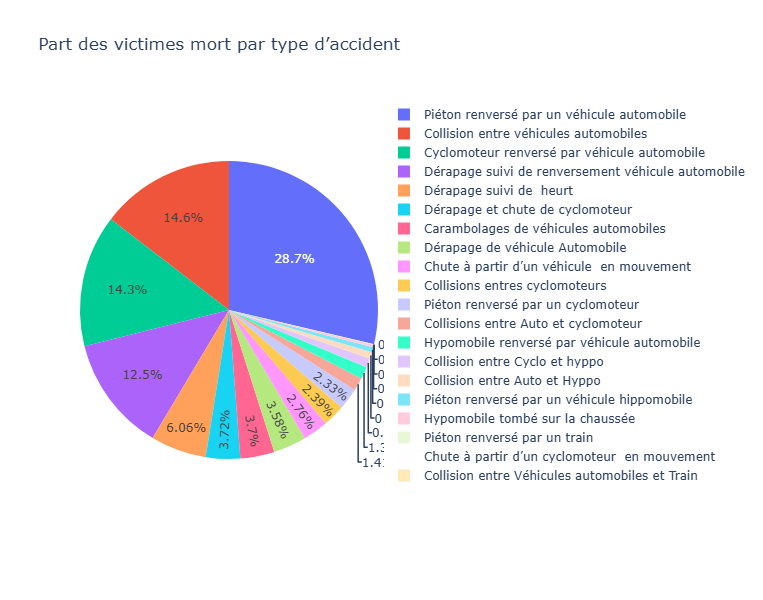

In [326]:
fig = px.pie(
    agg_deces.groupby("nature-de-l-accident")["Value"].sum().reset_index(),
    values='Value',
    names='nature-de-l-accident',
    title=' Part des victimes mort par type d’accident',
    width=900,     
    height=600
)
fig.show()


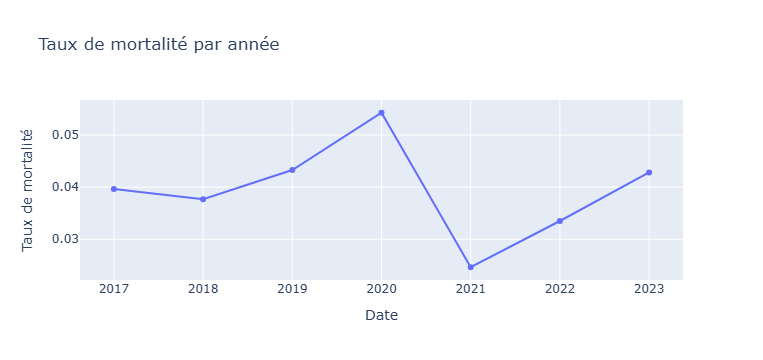

In [330]:
df_mort = df[df['sorties-et-victimes'] == 'Victimes décédées'].groupby('Date')['Value'].sum()
df_total = df[df['sorties-et-victimes'] == 'Nombre d\'accidents'].groupby('Date')['Value'].sum()

taux_mortalite = (df_mort / df_total).reset_index()
taux_mortalite.columns = ['Date', 'Taux de mortalité']

fig = px.line(
    taux_mortalite,
    x='Date',
    y='Taux de mortalité',
    title=' Taux de mortalité par année',
    markers=True
)
fig.show()


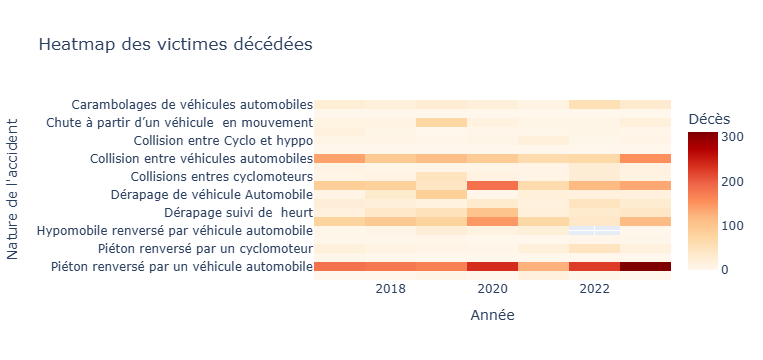

In [338]:
import plotly.graph_objects as go

pivot = agg_deces.pivot_table(
    index='nature-de-l-accident',
    columns='Date',
    values='Value',
    aggfunc='sum'
)

fig = px.imshow(
    pivot,
    labels=dict(x="Année", y="Nature de l'accident", color="Décès"),
    color_continuous_scale='OrRd',
    title="Heatmap des victimes décédées"
)
fig.show()


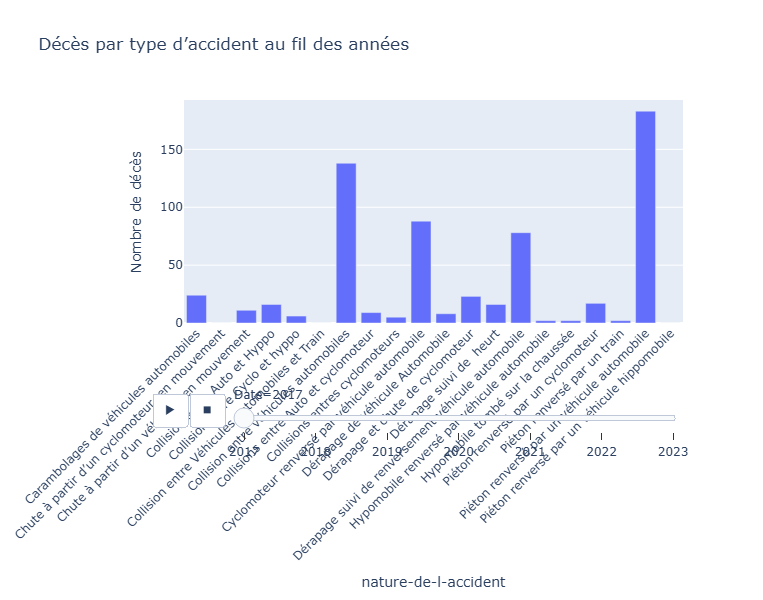

In [348]:
fig = px.bar(
    agg_deces,
    x="nature-de-l-accident",
    y="Value",
    animation_frame="Date",
    title="Décès par type d’accident au fil des années",
    labels={"Value": "Nombre de décès"},
)
fig.update_layout(height=600, xaxis_tickangle=-45)
fig.show()


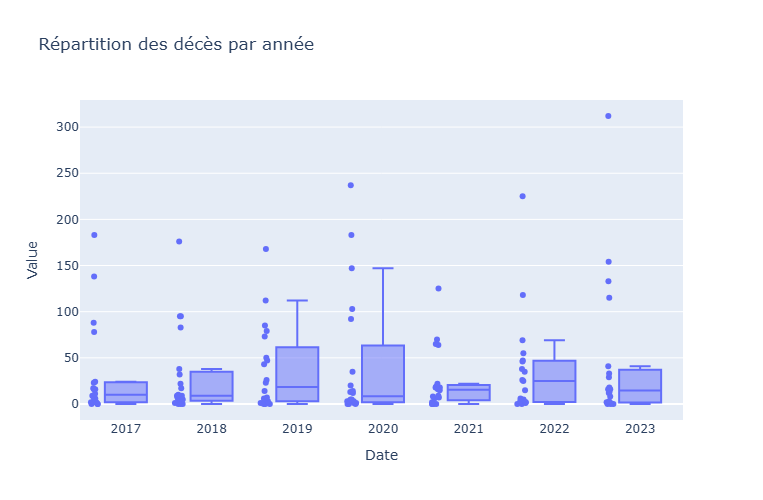

In [354]:
fig = px.box(
    agg_deces,
    x="Date",
    y="Value",
    points="all",
    title="Répartition des décès par année"
)
fig.update_layout(height=500)
fig.show()
